# Experiments

In [24]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import time
import networkx as nx
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch_geometric.utils import from_networkx

from utils.prep_data import load_data, split_data, mask_data, Experiment
from utils.train import train
from utils.dataset import WindFarmDataset
from GCGRU.GRU import GRU
from GCGRU.GCGRU import GCGRU

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Preprocess data

#### Load the data

In [25]:
data = load_data(columns=["TurbID", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv", "datetime"])
nan_mask = ~data["Patv"].isna().to_numpy()  # nans come in rows
# subset of turbines for faster experiments
turbines_idx = [9, 10, 11, 12, 31, 32, 33, 34, 35, 52, 53, 54, 55, 56, 57]
data = data[data["TurbID"].isin(turbines_idx)]

# dictionaries to map turbine ids to node ids and reverse
idx2turbine = {i: turb_id for i, turb_id in enumerate(turbines_idx)}
turbine2idx = {turb_id: i for i, turb_id in enumerate(turbines_idx)}

# normalize features
features = ["Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]
data[features] = data[features].apply(lambda col: ((col - col.min()) / (col.max() - col.min())))

train_data, val_data, test_data = split_data(data, splits=[0.7, 0.2, 0.1])

Split the nan masks

In [26]:
train_nan_mask = nan_mask[train_data.index]
val_nan_mask = nan_mask[val_data.index]
test_nan_mask = nan_mask[test_data.index]

Reset data split indices

In [27]:
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Assign corresponding split means to actual nan values

In [28]:
train_data.loc[:, features] = train_data[features].fillna(train_data[features].mean())

val_data.loc[:, features] = val_data[features].fillna(val_data[features].mean())

test_data.loc[:, features] = test_data[features].fillna(test_data[features].mean())

Load and process turbine locations

In [29]:
turbines = pd.read_csv('../data/turbines.csv', index_col=False)
turbines = turbines[turbines['TurbID'].isin(turbines_idx)]
turbines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 8 to 56
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TurbID  15 non-null     int64  
 1   x       15 non-null     float64
 2   y       15 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 480.0 bytes


In [30]:
x_min = turbines['x'].min()
x_max = turbines['x'].max()
y_min = turbines['y'].min()
y_max = turbines['y'].max()
turbines['x'] = (turbines['x'] - x_min) / (x_max - x_min)
turbines['y'] = (turbines['y'] - y_min) / (y_max - y_min)

In [31]:
pos_dict = {row["TurbID"].astype(int): (row["x"], row["y"]) for _, row in turbines.iterrows()}

### RNN-based models

In [32]:
def rnn_split_by_time(data: pd.DataFrame, nan_mask: np.ndarray, data_mask: np.ndarray, feature_cols: list, target_col: str):
    timestamps = data["datetime"].unique()
    timestamps = timestamps[timestamps.argsort()]

    xs = []
    ys = []
    nan_masks = []
    data_masks = []
    for i, curr_timestamp in enumerate(timestamps[:-1]):
        next_timestamp = timestamps[i+1]

        # sort to match with pytorch geometric node ids
        curr_df = data[data["datetime"] == curr_timestamp].sort_values("TurbID")
        next_df = data[data["datetime"] == next_timestamp].sort_values("TurbID")
        
        x = torch.tensor(curr_df[feature_cols].values)
        # simulate missing values on current data (normalized data, use 0.5)
        x[~data_mask[curr_df.index]] = 0.5
        xs.append(x)
        ys.append(torch.tensor(next_df[[target_col]].values))

        nan_masks.append(torch.tensor(nan_mask[next_df.index]))
        data_masks.append(torch.tensor(data_mask[next_df.index]))

    xs = torch.stack(xs).to(device)
    ys = torch.stack(ys).to(device)
    nan_masks = torch.stack(nan_masks).to(device)
    data_masks = torch.stack(data_masks).to(device)

    return xs, ys, nan_masks, data_masks

In [33]:
def format_sliding_window(xs: torch.Tensor, ys: torch.Tensor, nan_masks: torch.Tensor, data_masks: torch.Tensor, t: int = 6 * 24):
    X_window, y_window, nan_masks_window, data_masks_window = [], [], [], []
    for i in range(xs.shape[0] - t):
        X_window.append(xs[i:(i+t)])
        y_window.append(ys[i:(i+t)])

        nan_masks_window.append(nan_masks[i:(i+t)])
        data_masks_window.append(data_masks[i:(i+t)])

    return torch.stack(X_window), torch.stack(y_window), torch.stack(nan_masks_window), torch.stack(data_masks_window)

#### GRU

Define function to create separate GRU models per turbine and run experiment.

In [34]:
def add_position_to_data(data: torch.Tensor):
    # data - (T, N, F)
    data_positions = torch.tensor([pos_dict[idx2turbine[i]] for i in range(data.size(1))], dtype=data.dtype, device=device).unsqueeze(0).expand(data.size(0), -1, -1)  # (N, 2) tensor -> expand to (T, N, 2)
    
    # add positions -> data - (T, N, F+2)
    data = torch.cat([data, data_positions], dim=-1)
    return data

In [47]:
def GRU_experiment(experiments: dict, experiment: Experiment, size: float, fraction: float, feature_columns: list, target_column: str):
    print(f"Starting GRU experiment {experiment}, size={size}, fraction={fraction}...")
    print("Loading experiment data...")
    data_start_time = time.time()
    train_xs, train_ys, train_nan_masks, train_data_masks = rnn_split_by_time(train_data, train_nan_mask, experiments[experiment]["train"][(size, fraction)], feature_cols=feature_columns, target_col=target_column)
    val_xs, val_ys, val_nan_masks, val_data_masks = rnn_split_by_time(val_data, val_nan_mask, experiments[experiment]["val"][(size, fraction)], feature_cols=feature_columns, target_col=target_column)
    test_xs, test_ys, test_nan_masks, test_data_masks = rnn_split_by_time(test_data, test_nan_mask, experiments[experiment]["test"][(size, fraction)], feature_cols=feature_columns, target_col=target_column)

    train_xs = add_position_to_data(train_xs)
    val_xs = add_position_to_data(val_xs)
    test_xs = add_position_to_data(test_xs)

    def combine_turbine_windows(xs: torch.Tensor, ys: torch.Tensor, nan_masks: torch.Tensor, data_masks: torch.Tensor):
        X, y, nm, dm = [], [], [], []
        for turb_id in data["TurbID"].unique():
            turbine_X, turbine_y, turbine_nm, turbine_dm = format_sliding_window(xs[:, turbine2idx[turb_id], :], ys[:, turbine2idx[turb_id], :], nan_masks[:, turbine2idx[turb_id]], data_masks[:, turbine2idx[turb_id]])

            X.append(turbine_X)
            y.append(turbine_y)
            nm.append(turbine_nm)
            dm.append(turbine_dm)

        X = torch.cat(X)
        y = torch.cat(y)
        nm = torch.cat(nm)
        dm = torch.cat(dm)

        return X, y, nm, dm

    batch_size = 512

    train_X, train_y, train_nm, train_dm = combine_turbine_windows(train_xs, train_ys, train_nan_masks, train_data_masks)
    train_loader = DataLoader(WindFarmDataset(train_X, train_y, train_nm, train_dm), batch_size=batch_size, shuffle=True)

    val_X, val_y, val_nm, val_dm = combine_turbine_windows(val_xs, val_ys, val_nan_masks, val_data_masks)
    val_loader = DataLoader(WindFarmDataset(val_X, val_y, val_nm, val_dm), batch_size=batch_size, shuffle=True)
    
    test_X, test_y, test_nm, test_dm = combine_turbine_windows(test_xs, test_ys, test_nan_masks, test_data_masks)

    print(f"Data loading finished in {time.time() - data_start_time} seconds. Starting training...")

    start_time = time.time()

    lr = 0.01
    epochs = 100

    # +2 input features for positions
    model = GRU(len(feature_columns) + 2, 16, 1)
    optimizer = torch.optim.Adam(list(model.parameters()), lr=lr)
    criterion = torch.nn.MSELoss()

    model.to(device)
    criterion.to(device)

    print(f"Training GRU: ")
    model, train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, epochs=epochs, patience=5)
    print("\n----------------------------------------------------------\n")
    with torch.no_grad():
        test_preds = model(test_X)

        # Pure imputation task -> loss based on predicting simulated missing values correctly
        test_loss_mask = (test_nm == 1) & (test_dm == 0)
        test_loss = criterion(test_preds[test_loss_mask], test_y[test_loss_mask])
    print(f"Best model test loss: {test_loss.item():.4f}")
    print("\n\n")

    elapsed_time = time.time() - start_time
    print(f"Training took {elapsed_time:.3f} seconds")

    print("Saving losses and best model parameters...")
    os.makedirs(f"../data/experiment_results/{experiment}/{size}_{fraction}/GRU", exist_ok=True)
    torch.save(model.state_dict(), f"../data/experiment_results/{experiment}/{size}_{fraction}/GRU/params.pth")
    with open(f"../data/experiment_results/{experiment}/{size}_{fraction}/GRU/train_losses.csv", "w") as f:
        line = ",".join(map(str, train_losses))
        f.write(line)
    with open(f"../data/experiment_results/{experiment}/{size}_{fraction}/GRU/val_losses.csv", "w") as f:
        line = ",".join(map(str, val_losses))
        f.write(line)


#### GCGRU

Build the graph with the radius from the paper (1500m)

In [36]:
radius = 1500
radius_x = radius / (x_max - x_min)
radius_y = radius / (y_max - y_min)

In [37]:
G = nx.Graph()
turbines.apply(lambda x: G.add_node(int(x.TurbID), pos=(x.x, x.y)), axis=1)
G.nodes

NodeView((9, 10, 11, 12, 31, 32, 33, 34, 35, 52, 53, 54, 55, 56, 57))

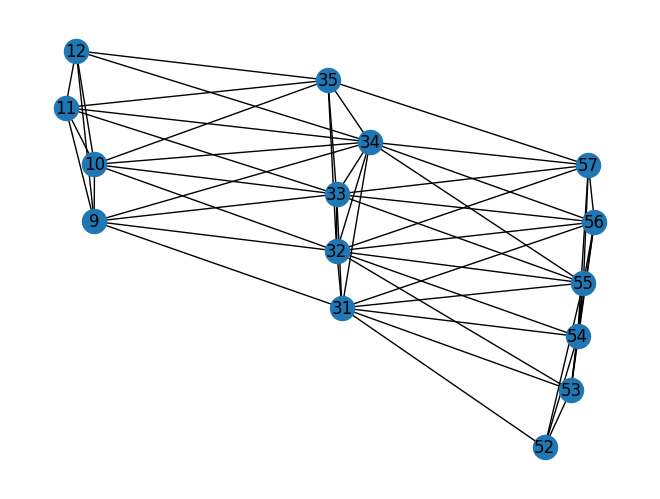

In [38]:
def construct_graph(turbine1, turbine2, radius_x, radius_y):
    n1 = int(turbine1.TurbID)
    n2 = int(turbine2.TurbID)
    if n1 < n2:
        distance = np.sqrt(((turbine2.x - turbine1.x) / radius_x)**2 + ((turbine2.y - turbine1.y) / radius_y)**2)
        if distance <= 1:
            G.add_edge(n1, n2)
turbines.apply(lambda x: turbines.apply(lambda y: construct_graph(x,y,radius_x, radius_y), axis=1),axis=1)
nx.draw(G, pos=pos_dict, labels={t: t for t in turbines_idx})

Define function to create the model and perform the experiment

In [48]:
def GCGRU_experiment(experiments: dict, experiment: Experiment, size: float, fraction: float | None, feature_columns: list, target_column: str):
    print(f"Starting GCGRU experiment {experiment}, size={size}, fraction={fraction}...")
    print("Loading experiment data...")
    data_start_time = time.time()
    train_xs, train_ys, train_nan_masks, train_data_masks = rnn_split_by_time(train_data, train_nan_mask, experiments[experiment]["train"][(size, fraction)], feature_cols=feature_columns, target_col=target_column)
    val_xs, val_ys, val_nan_masks, val_data_masks = rnn_split_by_time(val_data, val_nan_mask, experiments[experiment]["val"][(size, fraction)], feature_cols=feature_columns, target_col=target_column)
    test_xs, test_ys, test_nan_masks, test_data_masks = rnn_split_by_time(test_data, test_nan_mask, experiments[experiment]["test"][(size, fraction)], feature_cols=feature_columns, target_col=target_column)

    print(f"Data loading finished in {time.time() - data_start_time} seconds. Starting training...")
    model = GCGRU(in_dim=len(feature_columns), hid_dim=16, out_dim=1, edge_index=from_networkx(G).edge_index.to(device))

    lr = 0.01
    epochs = 100
    batch_size = 512
    optimizer = torch.optim.Adam(list(model.parameters()), lr=lr)
    criterion = torch.nn.MSELoss()

    model.to(device)
    criterion.to(device)

    start_time = time.time()

    train_X, train_y, train_nm, train_dm = format_sliding_window(train_xs, train_ys, train_nan_masks, train_data_masks)
    train_loader = DataLoader(WindFarmDataset(train_X, train_y, train_nm, train_dm), batch_size=batch_size, shuffle=True)

    val_X, val_y, val_nm, val_dm = format_sliding_window(val_xs, val_ys, val_nan_masks, val_data_masks)
    val_loader = DataLoader(WindFarmDataset(val_X, val_y, val_nm, val_dm), batch_size=batch_size, shuffle=True)

    print(f"Training GCGRU: ")
    model, train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, epochs=epochs, patience=5)
    print("\n----------------------------------------------------------\n")
    test_X, test_y, test_nm, test_dm = format_sliding_window(test_xs, test_ys, test_nan_masks, test_data_masks)
    with torch.no_grad():
        test_preds = model(test_X)

        # Pure imputation task -> loss based on predicting simulated missing values correctly
        test_loss_mask = (test_nm == 1) & (test_dm == 0)
        test_loss = criterion(test_preds[test_loss_mask], test_y[test_loss_mask])
    print(f"Best model test loss: {test_loss.item():.4f}")
    print("\n\n")

    elapsed_time = time.time() - start_time
    print(f"Training took {elapsed_time:.3f} seconds")

    print("Saving losses and best model parameters...")
    os.makedirs(f"../data/experiment_results/{experiment}/{size}_{fraction}/GCGRU", exist_ok=True)
    torch.save(model.state_dict(), f"../data/experiment_results/{experiment}/{size}_{fraction}/GCGRU/params.pth")
    with open(f"../data/experiment_results/{experiment}/{size}_{fraction}/GCGRU/train_losses.csv", "w") as f:
        line = ",".join(map(str, train_losses))
        f.write(line)
    with open(f"../data/experiment_results/{experiment}/{size}_{fraction}/GCGRU/val_losses.csv", "w") as f:
        line = ",".join(map(str, val_losses))
        f.write(line)

## Experiments

### Experiment setup

Create masks for different splits

In [ ]:
random_percentages = [(0.01, None), (0.02, None), (0.05, None), (0.1, None)]
blackout_periods = [(30, 0.01), (60, 0.01), (150, 0.01), (300, 0.01)]
# blackout_periods = [(30, 0.01), (30, 0.02), (30, 0.05), (30, 0.1), (60, 0.01), (60, 0.02), (60, 0.05), (60, 0.1), (150, 0.01), (150, 0.02), (150, 0.05), (150, 0.1), (300, 0.01), (300, 0.02), (300, 0.05), (300, 0.1)]
maintenance_periods = [(1, 0.01), (2, 0.01), (7, 0.01), (14, 0.01)]
# maintenance_periods = [(1, 0.01), (1, 0.02), (1, 0.05), (1, 0.1), (2, 0.01), (2, 0.02), (2, 0.05), (2, 0.1), (7, 0.01), (7, 0.02), (7, 0.05), (7, 0.1), (14, 0.01), (14, 0.02), (14, 0.05), (14, 0.1)]

In [41]:
train_masks_random = { (size, fraction): mask_data(train_data, base_mask=None, experiment=Experiment.RANDOM, size = size, fraction=fraction) for (size, fraction) in random_percentages }
val_masks_random = { (size, fraction): mask_data(val_data, base_mask=None, experiment=Experiment.RANDOM, size = size, fraction=fraction) for (size, fraction) in random_percentages }
test_masks_random = { (size, fraction): mask_data(test_data, base_mask=None, experiment=Experiment.RANDOM, size = size, fraction=fraction) for (size, fraction) in random_percentages }

In [42]:
train_masks_blackout = { (size, fraction): mask_data(train_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size, fraction=fraction) for (size, fraction) in blackout_periods }
val_masks_blackout = { (size, fraction): mask_data(val_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size, fraction=fraction) for (size, fraction) in blackout_periods }
test_masks_blackout = { (size, fraction): mask_data(test_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size, fraction=fraction) for (size, fraction) in blackout_periods }

In [43]:
train_masks_maintenance = { (size, fraction): mask_data(train_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size, fraction=fraction) for (size, fraction) in maintenance_periods }
val_masks_maintenance = { (size, fraction): mask_data(val_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size, fraction=fraction) for (size, fraction) in maintenance_periods }
test_masks_maintenance = { (size, fraction): mask_data(test_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size, fraction=fraction) for (size, fraction) in maintenance_periods }

In [44]:
experiments = {
    Experiment.RANDOM: {
        "train": train_masks_random,
        "val": val_masks_random,
        "test": test_masks_random,
    },
    Experiment.BLACKOUT: {
        "train": train_masks_blackout,
        "val": val_masks_blackout,
        "test": test_masks_blackout,
    },
    Experiment.MAINTENANCE: {
        "train": train_masks_maintenance,
        "val": val_masks_maintenance,
        "test": test_masks_maintenance,
    }
}

Define feature / target columns to use

In [45]:
feature_columns = ["Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]  # features should be normalized during preprocess
target_column = "Patv"  # P_norm not used, since all features are normalized at notebook start

### Run experiments

Run all experiments for GRU

In [23]:
for size, fraction in random_percentages:
    GRU_experiment(experiments, Experiment.RANDOM, size, fraction, feature_columns, target_column)

Starting GRU experiment Experiment.RANDOM, size=0.01, fraction=None...
Loading experiment data...
Data loading finished in 120.23708033561707 seconds. Starting training...
Training GRU: 
Epoch: 1;	training loss: 0.0093;	validation loss: 0.0043
Epoch: 10;	training loss: 0.0036;	validation loss: 0.0045
Stopping early on epoch 12

----------------------------------------------------------

Best model test loss: 0.0039



Training took 2086.940 seconds
Saving losses and best model parameters...
Starting GRU experiment Experiment.RANDOM, size=0.02, fraction=None...
Loading experiment data...
Data loading finished in 114.95770692825317 seconds. Starting training...
Training GRU: 
Epoch: 1;	training loss: 0.0095;	validation loss: 0.0038
Epoch: 10;	training loss: 0.0048;	validation loss: 0.0050
Stopping early on epoch 13

----------------------------------------------------------

Best model test loss: 0.0028



Training took 2229.737 seconds
Saving losses and best model parameters...
Starting

In [49]:
for size, fraction in blackout_periods:
    GRU_experiment(experiments, Experiment.BLACKOUT, size, fraction, feature_columns, target_column)

Starting GRU experiment Experiment.BLACKOUT, size=30, fraction=0.01...
Loading experiment data...
Data loading finished in 123.21027684211731 seconds. Starting training...
Training GRU: 
Epoch: 1;	training loss: 0.0185;	validation loss: 0.0100
Stopping early on epoch 7

----------------------------------------------------------

Best model test loss: 0.0062



Training took 1192.834 seconds
Saving losses and best model parameters...
Starting GRU experiment Experiment.BLACKOUT, size=60, fraction=0.01...
Loading experiment data...
Data loading finished in 122.11786460876465 seconds. Starting training...
Training GRU: 
Epoch: 1;	training loss: 0.0248;	validation loss: 0.0178
Stopping early on epoch 9

----------------------------------------------------------

Best model test loss: 0.0057



Training took 1567.230 seconds
Saving losses and best model parameters...
Starting GRU experiment Experiment.BLACKOUT, size=150, fraction=0.01...
Loading experiment data...
Data loading finished in 12

In [51]:
for size, fraction in maintenance_periods:
    GRU_experiment(experiments, Experiment.MAINTENANCE, size, fraction, feature_columns, target_column)

Starting GRU experiment Experiment.MAINTENANCE, size=1, fraction=0.01...
Loading experiment data...


KeyboardInterrupt: 

Run all experiments for GCGRU

In [46]:
for size, fraction in random_percentages:
    GCGRU_experiment(experiments, Experiment.RANDOM, size, fraction, feature_columns, target_column)

Starting GCGRU experiment Experiment.RANDOM, size=0.01, fraction=None...
Loading experiment data...
Data loading finished in 109.20739078521729 seconds. Starting training...
Training GCGRU: 
Epoch: 1;	training loss: 0.0173;	validation loss: 0.0067
Epoch: 10;	training loss: 0.0098;	validation loss: 0.0054
Epoch: 20;	training loss: 0.0086;	validation loss: 0.0056
Stopping early on epoch 20

----------------------------------------------------------

Best model test loss: 0.0038



Training took 1572.443 seconds
Saving losses and best model parameters...
Starting GCGRU experiment Experiment.RANDOM, size=0.02, fraction=None...
Loading experiment data...
Data loading finished in 110.34251546859741 seconds. Starting training...
Training GCGRU: 
Epoch: 1;	training loss: 0.0223;	validation loss: 0.0078
Epoch: 10;	training loss: 0.0105;	validation loss: 0.0061
Epoch: 20;	training loss: 0.0098;	validation loss: 0.0060
Epoch: 30;	training loss: 0.0089;	validation loss: 0.0066
Stopping early on ep

In [50]:
for size, fraction in blackout_periods:
    GCGRU_experiment(experiments, Experiment.BLACKOUT, size, fraction, feature_columns, target_column)

Starting GCGRU experiment Experiment.BLACKOUT, size=30, fraction=0.01...
Loading experiment data...
Data loading finished in 152.76823687553406 seconds. Starting training...
Training GCGRU: 
Epoch: 1;	training loss: 0.0226;	validation loss: 0.0069
Stopping early on epoch 9

----------------------------------------------------------

Best model test loss: 0.0047



Training took 1114.517 seconds
Saving losses and best model parameters...
Starting GCGRU experiment Experiment.BLACKOUT, size=60, fraction=0.01...
Loading experiment data...
Data loading finished in 112.77786064147949 seconds. Starting training...
Training GCGRU: 
Epoch: 1;	training loss: 0.0308;	validation loss: 0.0074
Epoch: 10;	training loss: 0.0093;	validation loss: 0.0068
Stopping early on epoch 11

----------------------------------------------------------

Best model test loss: 0.0035



Training took 893.686 seconds
Saving losses and best model parameters...
Starting GCGRU experiment Experiment.BLACKOUT, size=150, fra

In [ ]:
for size, fraction in maintenance_periods:
    GCGRU_experiment(experiments, Experiment.MAINTENANCE, size, fraction, feature_columns, target_column)